<center><font size="7">Scikit-Learn exploration</font></center>




<font size="4">Copyright Christophe PERE 24/04/2017</font>

<b><i>What's the goal of this study ? </i></b>

It's simple, in the previous study - Car's Behavior - we have explore the data to understand the relationship between all the parameters. Determine if we could predict an estimation of the price of a car in the futur and determine what are the important parameters to do this. Here, it's more simple or complicated. We take the precedent approach concerning the cleaning of the data and use the Scikit-learn library available in Python to develop algorithms and models in order to evaluate the data. 

We'll detail a lot the PCA part, consist of studying the number of parameters and reduice it. At the end, the exploration will pass at another level with the implementation of machine learning algorithms. 

<span style="color:red"><font size="6">I - Precedent study </font></span>

In [1]:
%matplotlib inline                          
# Mandatory in jupyter's notebook if you want to see your plot
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import math as M
from scipy.optimize import curve_fit
from time import mktime


In [2]:
# ---- Scikit-learn modules -------------------------
from sklearn import linear_model

In [3]:
# Let's began with the site 'LaCentrale.fr' and a subdataframe with brands 'PEUGEOT, CITROEN and DS AUTOMOBILES' 
name = '../Docs/Files_FR/Etude_Christophe/car_FR_PSA_lacentrale.csv'
# Open the gzip file and convert all the data in string format, separate the columns with the delimiter ';'
df = pd.read_csv(name+'.gzip', sep=';', dtype=str, compression='gzip')     # load the csv file 
head = list(df)                                        # Get the name of the columns 
print(head)                                            # Show the names 

['data_month', 'MARQUE_CORRECTED', 'MODELE_CORRECTED', 'CARROSSERIE_CORRECTED', 'CARBURANT_CORRECTED', 'LITRE', 'PUISSANCE_CORRECTED', 'BOITE_CORRECTED', '4RM', 'PRIX', 'KM', 'ANNEE', 'MOIS', 'PORTE_CORRECTED', 'doublon_id_2', 'site']


In [4]:
def func_treatment(data, head, year):

    pd.options.mode.chained_assignment = None                       # permit to avoid error in copying 
    
    cols = [head[1], head[2],head[3],head[4]]
    for c in cols:
        data[c] = pd.to_numeric(data[c], errors='coerce')           # cast the type str to numeric
        
    # Select a part of the dataframe where the year is > at year passed in the function 
    data = data[(data[head[3]].astype(int)<=datetime.now().year) & (data[head[3]].astype(int)>=year) ]
    data = data[data[head[4]]>0]
    # ---- Date creation --------------------------------------------
    #a = data[head[4]].apply(lambda x : x if x>0 else 1)             # Month can be = 0 when not found in the crawl 
    #data[head[4]]=a.values                                          # so, it's better to fix them at 1 
    a = data[head[4]].apply(lambda x : str(x) if x>=10 else '0'+str(x))# string format and add a 0 when the month is 
    data[head[4]]=a.values                                          # < 10 (01, 02, 03...)
    
    date = data[head[3]].astype(str)+'-'+data[head[4]]              # concat the year-month to generate the Date
    data['Date'] = date.values                                      # .astype() permit to cast a type to another     
                                                                    # passed in the () 
    data_month = [i.split('/') for i in data.data_month]            # 
    data_month = [i[2]+'-'+i[1] for i in data_month]
    data.data_month=data_month
    #print(data.data_month[:5])
    #print(data.data_month.iat[0],'%Y-%m')
    size = len(data)
    date_delta=[datetime.strptime(data.data_month.iat[i],'%Y-%m')-datetime.strptime(data.Date.iat[i],'%Y-%m') \
              for i in range(size)]
    #print(date_delta[0].days/30)
    date_age=[round(i.days/30) for i in date_delta] #round
    data['Age_months']=date_age
    data = data[data.Age_months>=0]
    # ---- Data cleaning --------------------------------------------
    a = data[head[0]].fillna(' ')
    data[head[0]] = a.values
    a = data[head[1]].apply(lambda x : x if x>0 else 0 )
    data[head[1]] = a.values
    
    return data



In [5]:
model = 'C3'     

In [6]:
df_carac = df[['MODELE_CORRECTED', 'PRIX', 'KM', 'ANNEE', 'MOIS','CARROSSERIE_CORRECTED', \
               'CARBURANT_CORRECTED', 'LITRE', 'PUISSANCE_CORRECTED', 'BOITE_CORRECTED',  \
               '4RM',  'PORTE_CORRECTED','data_month']]
head = list(df_carac)
print(head)

['MODELE_CORRECTED', 'PRIX', 'KM', 'ANNEE', 'MOIS', 'CARROSSERIE_CORRECTED', 'CARBURANT_CORRECTED', 'LITRE', 'PUISSANCE_CORRECTED', 'BOITE_CORRECTED', '4RM', 'PORTE_CORRECTED', 'data_month']


In [7]:
df_model = df_carac[df_carac[head[0]]==model]           # select a subdataframe with the model pass in part II

In [8]:
year_min = 2000  
df_model = func_treatment(df_model,list(df_model),year_min)
print(df_model.head())

   MODELE_CORRECTED   PRIX      KM  ANNEE MOIS CARROSSERIE_CORRECTED  \
11               C3   5950  109700   2012   05               SOCIETE   
12               C3   7950   89800   2012   07               BERLINE   
17               C3  12490   13015   2015   01               BERLINE   
23               C3  17100    9000   2015   08               BERLINE   
25               C3   4500  148000   2008   01               BERLINE   

   CARBURANT_CORRECTED LITRE PUISSANCE_CORRECTED BOITE_CORRECTED 4RM  \
11              DIESEL   1.4                  68        MANUELLE   N   
12              DIESEL   1.4                  68     AUTOMATIQUE   N   
17              DIESEL   1.4                  68        MANUELLE   N   
23              DIESEL   1.6                  99        MANUELLE   N   
25              DIESEL   1.4                  68        MANUELLE   N   

   PORTE_CORRECTED data_month     Date  Age_months  
11               5    2016-02  2012-05          46  
12               5    2016-0

In [9]:
def func_outliers(data):                                       # remove outliers from data

    years = data[head[3]].unique()                             # list of years unique
    years = list(years)
    years.sort()                                               # sort the list ascending
    t = []
    if(len(years)<3):                                          # if we have 1 or 2 years we take all the data
        return data
    for i in years :
        df = data[data[head[3]]==i]                            # select a subdataframe by year
        months = df[head[4]].unique()                          # return a list of month
        for j in months:
            df2 = df[df[head[4]]==j]                           # select a subsubdataframe by month in the year
            mean = df2[head[1]].median(axis=0)                 # compute the median of the price for the month
            std  = df2[head[1]].std(axis=0)                    # compute the standard deviation
            df_fin = df2[(df2[head[1]] < (mean+ 3* std)) ]     # select price in the interval median+/-2std
            df_fin = df_fin[(df_fin[head[1]]>(mean-3*std))]
            t.append(df_fin)                                   # create a list of subsubdataframe
        d = pd.concat(t, axis=0)                               # create a final dataframe of the points without 
                                                               # outliers
    d = d.drop_duplicates(d[['PRIX','KM','Date']],keep='last')
    d = d[d.KM<200000]
    return d

In [10]:
df_select = func_outliers(df_model)
#print(df_select.head())
#df_select = df_select.sort_values(by='Date', ascending=False)
print(df_select[['PRIX','KM','Date','data_month','Age_months']].head(5))

       PRIX      KM     Date data_month  Age_months
1161   2300  162000  2002-07    2016-02         165
9943   3499  171950  2002-07    2016-02         165
13708  3490  118655  2002-07    2016-02         165
67950  2300  199752  2002-07    2016-03         166
68563  3290  142200  2002-07    2016-03         166


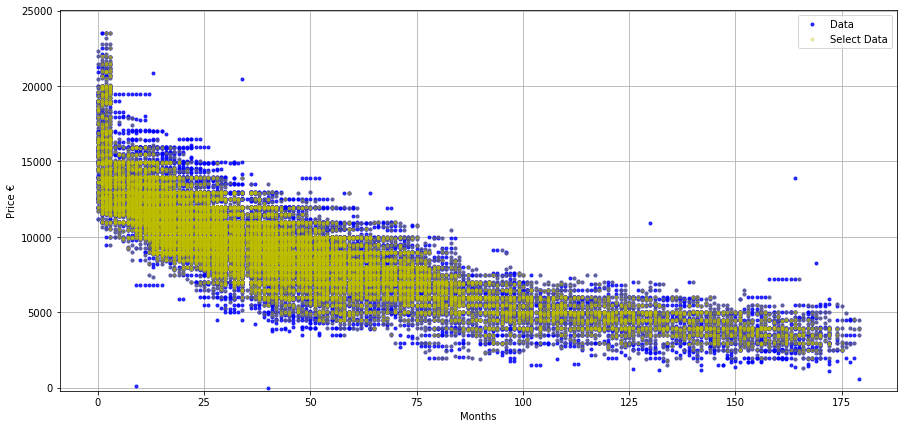

In [11]:
fig = plt.figure(figsize=(15,7))
plt.plot(df_model.Age_months, df_model.PRIX, 'b.', alpha=0.8, label='Data')
plt.plot(df_select.Age_months, df_select.PRIX, 'y.', alpha=0.3, label='Select Data')
plt.ylim(df_select.PRIX.min()-1500, df_select.PRIX.max()+1500)
plt.legend()
plt.xlabel('Months')
plt.ylabel('Price €')
plt.grid(True)

In [46]:
def func_mean_median(data, name):
    # ---- Mean Median computation --------------------------
    
    mean = []                                # Empty list to stock the results of the computation
    median = []
    err = []
    km_value = []
    for i in data[name].unique():
        d  = data[data[name]==i]             # Select a subdataframe by date
        z  = d[head[1]].mean(axis=0)         # Compute the mean of the price
        z4 = d[head[1]].std(axis=0)          # Compute the standard deviation of the price 
        z2 = d[head[1]].median(axis=0)       # Compute the median of the price
        z3 = d[head[2]].mean(axis=0)         # Compute the mean of the kilometer
        mean.append(z)                       # Save the values in the lists 
        median.append(z2)
        err.append(z4)
        km_value.append(z3)
        
    dict_values = { name   :pd.Series(np.array(df_select[name].unique())),
                   'Mean'  :pd.Series(np.array(mean)),
                   'Median':pd.Series(np.array(median)),
                   'Error' :pd.Series(np.array(err)),
                   'km'    :pd.Series(np.array(km_value)) }
    # Pass from dict to dataframe by specifying the name of the columns - correspond to the columns' order
    df_results = pd.DataFrame(columns = [name, 'Mean','Median','Error','km'],data=dict_values)


    return df_results

In [47]:
df_results  = func_mean_median(df_select, 'Age_months')
#df_results = df_results.sort_values(by='Date')             # sort the dataframe by date

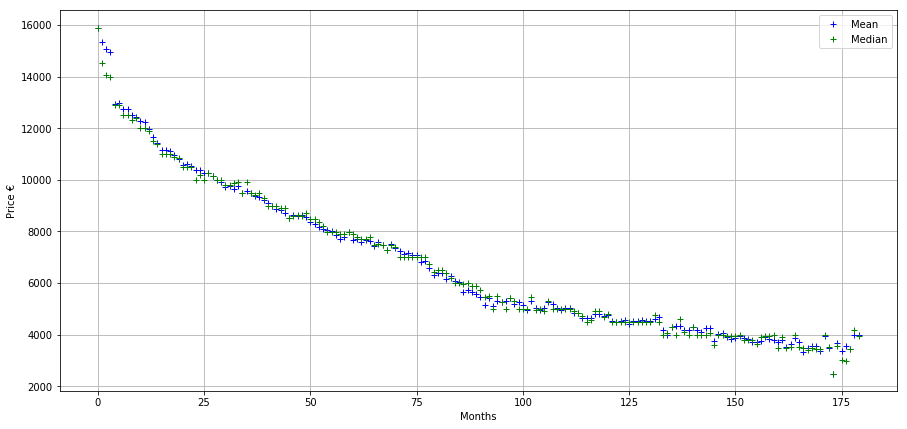

In [48]:
fig = plt.figure(figsize=(15,7))
plt.plot(df_select.Age_months.unique(), df_results.Mean, 'b+', label='Mean')
plt.plot(df_select.Age_months.unique(), df_results.Median, 'g+', label='Median')
plt.legend()
plt.xlabel('Months')
plt.ylabel('Price €')
plt.grid(True)

In [15]:
def func_reverse(df_results):
    size = len(df_results)-1                                      # Stock the length -1 in a variable 
    # save the time_delta between to successive dates 2012-01 - 2013-01 --> 365 days
    date_delta=[datetime.strptime(df_results.Date[size-i],'%Y-%m')-datetime.strptime(df_results.Date[size-i-1],'%Y-%m') \
              for i in range(len(df_results.Date)-1)]
    date = list(np.ones(len(date_delta)+1))                       # Generate a list with all values = 1
    date[0]=datetime.strptime(df_results.Date.iat[size], '%Y-%m') # initialise the list with the last value in the 
                                                                  # initial date

    for i in range(len(date_delta)):                              # Loop to create the new date with the time_delta
         date[i+1]=date[i]+date_delta[i]

    # Transform the new date %Y-%m
    new_date = [str(i.year)+'-'+str(i.month) if i.month>=10 else str(i.year)+'-0'+str(i.month) for i in date]   
    new_date.sort()
    df_results['New_date']=new_date[::-1]                         # Create new columns in the dataframe 
    
    # convert the date in days (since the 1970-01-01, Unix time)
    x_new = [mktime(datetime.strptime(i, '%Y-%m').timetuple())/86400 for i in df_results.New_date ]
    x_new = [i - x_new[len(x_new)-1] for i in x_new]          # Now pass the origin to x = 0 
    x_new.sort()
    df_results['Unix_day']=x_new[::-1]
    
    return df_results

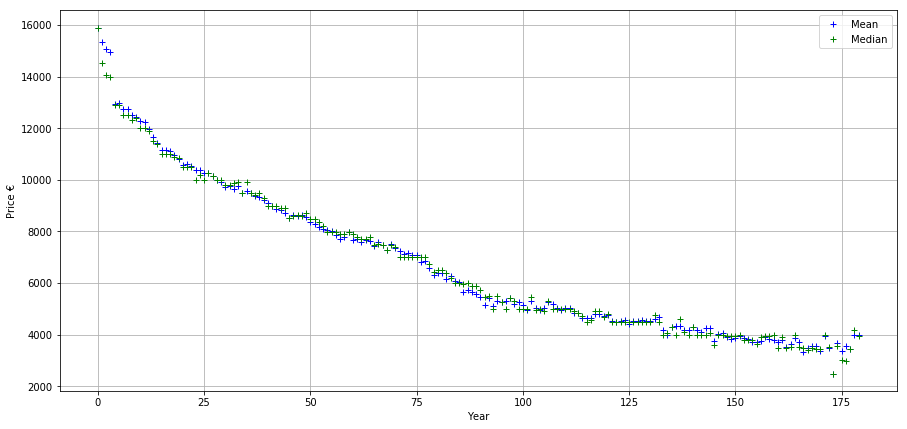

In [16]:
#df_results = func_reverse(df_results)
fig = plt.figure(figsize=(15,7))
plt.plot(df_results.Age_months, df_results.Mean, 'b+', label='Mean')
plt.plot(df_results.Age_months, df_results.Median, 'g+', label='Median')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Price €')
plt.grid(True)

<span style="color:red"><font size="6">II - Scikit-Exploration </font></span>

<span style="color:blue"><font size="5">1 - Linear Approach </font></span>

In [17]:
# ---- Data select ---------------------------------------------
X = df_results.Age_months
X = np.array(X).reshape((len(X), 1))                                 # use like a matrix 
#print(X)
y1 = df_results.Median.values
y1 = np.array(y1).reshape((len(y1), 1))

y2 = df_results.Mean.values
y2 = np.array(y2).reshape((len(y2), 1))

In [18]:
model1 = linear_model.Lasso(alpha=1e-6)                             # Linear Regression of the sklearn package
model2 = linear_model.LinearRegression()    

In [19]:
model1.fit(X, y1)                                                    # fit the x and y value with the fit() function

Lasso(alpha=1e-06, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [20]:
model2.fit(X, y2)                                                    # fit the x and y value with the fit() function

/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [21]:
x_new = np.linspace(0,df_results.Age_months.max(), len(df_results))
x_new = np.array(x_new).reshape((len(x_new), 1))                     # reshape the data to avoid ValueError

In [22]:
y_new1 = model1.predict(x_new)                                       # use the predict() function to estimate the
y_new2 = model2.predict(x_new)                                       # new x values with the linear model

In [23]:
x_fin = [i[0] for i in x_new]                                        # create a list with the first value of each tuple

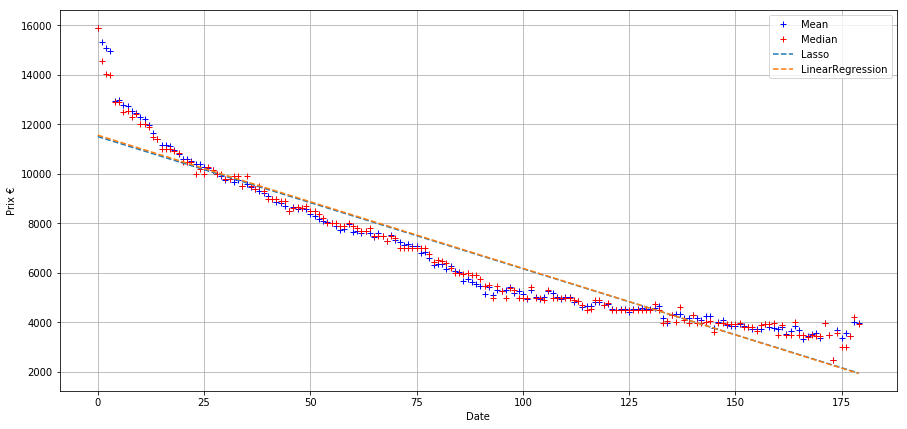

In [24]:
plt.figure(figsize=(15,7))
plt.plot(df_results.Age_months, df_results.Mean, 'b+', label='Mean')
plt.plot(df_results.Age_months, df_results.Median, 'r+', label='Median')
plt.plot(x_fin,y_new1, '--',  label='Lasso')
plt.plot(x_fin,y_new2, '--',  label='LinearRegression')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Prix €')
plt.legend()
plt.show()

<span style="color:blue"><font size="5">2 - Kernel Ridge Regression </font></span>

In [25]:
from sklearn.kernel_ridge import KernelRidge                  # import module

In [26]:
model1 = KernelRidge(alpha=1e-2, kernel='chi2')               
# kernel = linear, cosine, sigmoid, polynomial, laplcian, chi2, rbf 

In [27]:
model1.fit(X, y1) 

KernelRidge(alpha=0.01, coef0=1, degree=3, gamma=None, kernel='chi2',
      kernel_params=None)

In [28]:
y_KRR = model1.predict(x_new) 

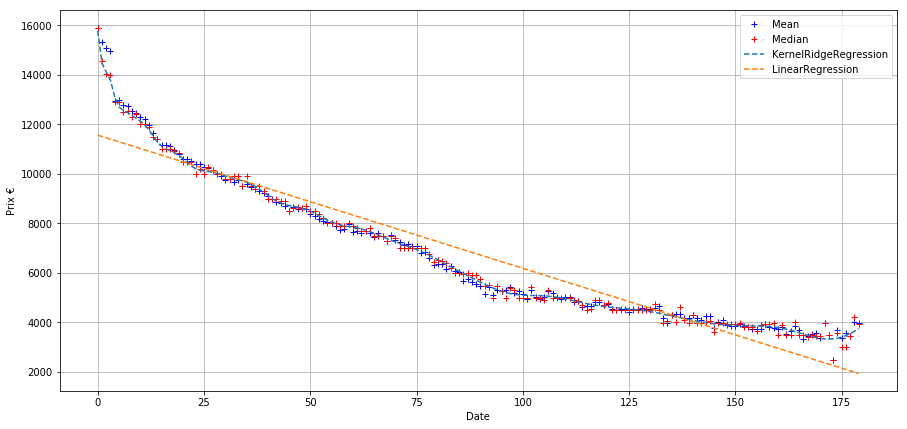

In [29]:
plt.figure(figsize=(15,7))
plt.plot(df_results.Age_months, df_results.Mean, 'b+', label='Mean')
plt.plot(df_results.Age_months, df_results.Median, 'r+', label='Median')
plt.plot(x_fin,y_KRR, '--',  label='KernelRidgeRegression')
plt.plot(x_fin,y_new2, '--',  label='LinearRegression')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Prix €')
plt.legend()
plt.show()

In [30]:
print(model1.score(X, y1))

0.996583032444


<span style="color:blue"><font size="5">3 - Support Vector Machines (SVM) </font></span>

In [31]:
from sklearn import svm                 

In [32]:
model1 = svm.SVC(gamma=0.001, C=1000.)                                       
# kernels can be linear, rbf (radial), polynomial and sigmoid

In [33]:
#y1 = np.array(y1).reshape((len(y1), ))
#model1.fit(X,y1) # that generate an error, the y1 values need to be transorfmed with the package preprocessing

This error appears because the values are not <i>int</i> values but float. If you convert it to <i>int</i> it will be accepted as input (although it will be questionable if that's the right way to do it).
It would be better to convert the training scores by using scikit's labelEncoder function.
The same is true for the DecisionTree and KNeighbors qualifier.

In [34]:
from sklearn import preprocessing
from sklearn import utils

In [35]:
y1 = np.array(y1).reshape((len(y1), ))

In [36]:
lab_enc = preprocessing.LabelEncoder()
encoded = lab_enc.fit_transform(y1)

In [37]:
model1.fit(X,encoded)

SVC(C=1000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [38]:
y_new1 = model1.predict(x_new)

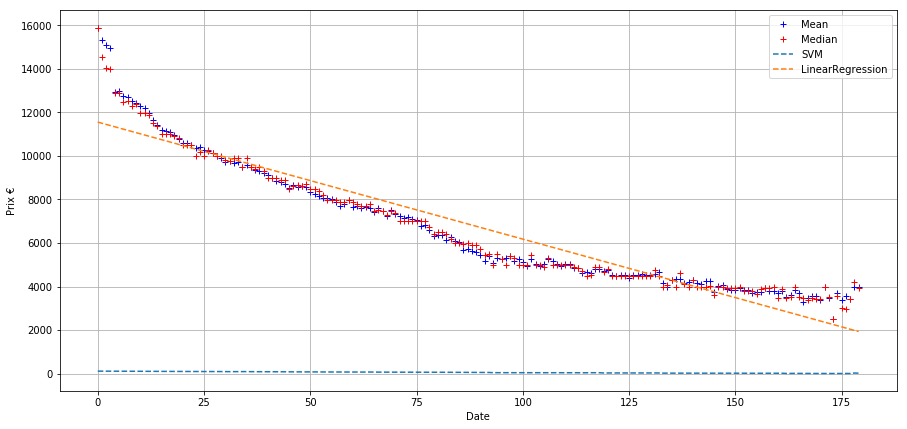

In [39]:
plt.figure(figsize=(15,7))
plt.plot(df_results.Age_months, df_results.Mean, 'b+', label='Mean')
plt.plot(df_results.Age_months, df_results.Median, 'r+', label='Median')
plt.plot(x_fin,y_new1, '--',  label='SVM')
plt.plot(x_fin,y_new2, '--',  label='LinearRegression')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Prix €')
plt.legend()
plt.show()

In [40]:
print(model1.support_vectors_)

[[ 173.]
 [ 176.]
 [ 175.]
 [ 167.]
 [ 169.]
 [ 170.]
 [ 177.]
 [ 168.]
 [ 162.]
 [ 166.]
 [ 160.]
 [ 172.]
 [ 165.]
 [ 163.]
 [ 174.]
 [ 145.]
 [ 155.]
 [ 152.]
 [ 153.]
 [ 154.]
 [ 161.]
 [ 156.]
 [ 148.]
 [ 150.]
 [ 158.]
 [ 179.]
 [ 157.]
 [ 149.]
 [ 159.]
 [ 171.]
 [ 151.]
 [ 141.]
 [ 142.]
 [ 146.]
 [ 147.]
 [ 139.]
 [ 133.]
 [ 164.]
 [ 136.]
 [ 143.]
 [ 144.]
 [ 134.]
 [ 138.]
 [ 178.]
 [ 140.]
 [ 135.]
 [ 132.]
 [ 124.]
 [ 127.]
 [ 128.]
 [ 115.]
 [ 121.]
 [ 122.]
 [ 125.]
 [ 130.]
 [ 126.]
 [ 129.]
 [ 123.]
 [ 116.]
 [ 137.]
 [ 119.]
 [ 114.]
 [ 131.]
 [ 120.]
 [ 113.]
 [ 112.]
 [ 117.]
 [ 118.]
 [ 105.]
 [ 103.]
 [ 111.]
 [ 107.]
 [ 109.]
 [ 110.]
 [ 104.]
 [  99.]
 [ 101.]
 [  93.]
 [  96.]
 [  95.]
 [  98.]
 [ 106.]
 [  97.]
 [ 102.]
 [  91.]
 [  94.]
 [  92.]
 [  90.]
 [  88.]
 [  89.]
 [  86.]
 [  85.]
 [  87.]
 [  84.]
 [  83.]
 [  82.]
 [  79.]
 [  81.]
 [  80.]
 [  78.]
 [  77.]
 [  76.]
 [  71.]
 [  74.]
 [  75.]
 [  68.]
 [  70.]
 [  65.]
 [  67.]
 [  69.]
 [  66.]
 

In [41]:
print(model1.support_)

[  6  11   7  16   3   4   8   2  13   1  30   5   0  14  10  36  25  22
  23  24  17  26  19  20  28  18  27  31  29   9  21  32  33  37  38  42
  47  15  39  34  35  48  41  12  43  49  46  50  53  54  60  66  67  51
  44  52  55  56  61  40  64  59  45  65  58  57  62  63  80  79  68  70
  72  73  74  75  77  83  86  85  81  69  82  78  90  84  91  89  87  88
  99  98  92  97  96  95 102  94  93 101 100 104 113 116 103 110 112 107
 109 111 108 120 105 119 106 118 125 126 117 122 123 124 121 128 133 127
 135 129 131 130 132 134 137 136 138 140 150 149 151 148 146 145 147 152
 153 143 144 156 158 142 157 141 155 159 164 163 160 162 165 166 173 171
 172 169 170 167 168 174 176 175 177 178 179]


In [42]:
print(model1.n_support_)

[1 1 1 1 1 2 2 1 1 1 2 1 1 1 1 2 2 3 1 2 1 8 2 1 1 1 1 1 2 6 1 1 4 1 1 1 1
 1 1 1 4 1 8 1 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 1 1 1 4 1 1 1 3 1 1 1 1 1 3
 4 1 1 1 1 1 2 1 1 2 2 1 1 2 1 1 1 1 2 4 1 1 1 2 1 1 2 1 1 1 2 1 1 1 1 2 1
 1 1 1]


<span style="color:blue"><font size="5">4 - SVR </font></span>

In [90]:
model1 = svm.SVR(kernel='rbf',gamma=0.001, C=100000.)

In [91]:
model1.fit(X,y1)

SVR(C=100000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [92]:
y_SVR = model1.predict(x_new)

In [132]:
model2 = svm.SVR(kernel='rbf',gamma=0.0001, C=100000.)

In [133]:
X2 = df_results.km.sort_values(ascending=False )
X2 = X2.values
X2 = np.array(X2).reshape(len(X2),1)
model2.fit(X2,y1)
x_new2 = np.linspace(0,df_results.km.max(), len(df_results))
x_new2 = np.array(x_new2).reshape(len(x_new2),1)
y_SVR2 = model2.predict(X2)
x_fin2 = np.array(X2).reshape(len(X2),)

In [134]:
#print(list(zip(x_fin2,X2.reshape(len(X2),))))


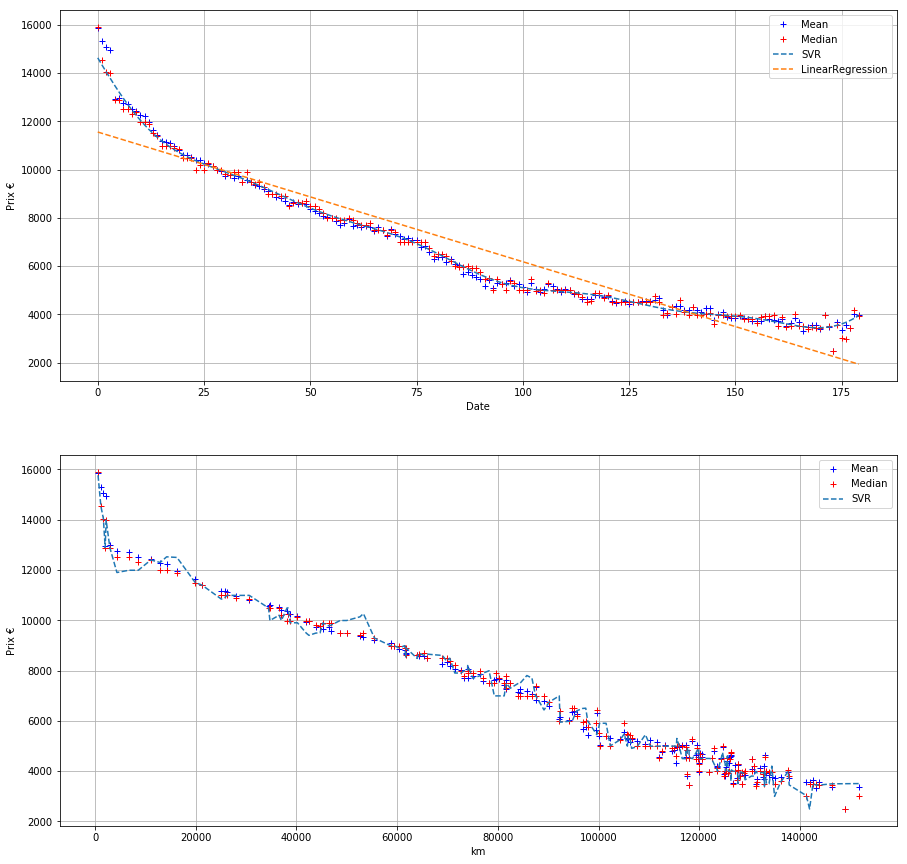

In [135]:
plt.figure(figsize=(15,15))
ax1 = plt.subplot(211)
plt.plot(df_results.Age_months, df_results.Mean, 'b+', label='Mean')
plt.plot(df_results.Age_months, df_results.Median, 'r+', label='Median')
plt.plot(x_fin,y_SVR, '--',  label='SVR')
plt.plot(x_fin,y_new2, '--',  label='LinearRegression')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Prix €')
plt.legend()
ax2 = plt.subplot(212)
plt.plot(df_results.km, df_results.Mean, 'b+', label='Mean')
plt.plot(df_results.km, df_results.Median, 'r+', label='Median')
plt.plot(x_fin2,y_SVR2, '--',  label='SVR')
plt.grid(True)
plt.xlabel('km')
plt.ylabel('Prix €')
plt.legend()
plt.show()

In [95]:
print(model1.score(X,y1),model2.score(X2,y1) )

0.994397534186 0.999999998814


<span style="color:blue"><font size="5">5 - Gaussian Process Regression </font></span>

In [136]:
from sklearn import gaussian_process

In [137]:
model1 = gaussian_process.GaussianProcessRegressor()

In [138]:
model1.fit(X,y1)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [139]:
y_GPR = model1.predict(x_new)

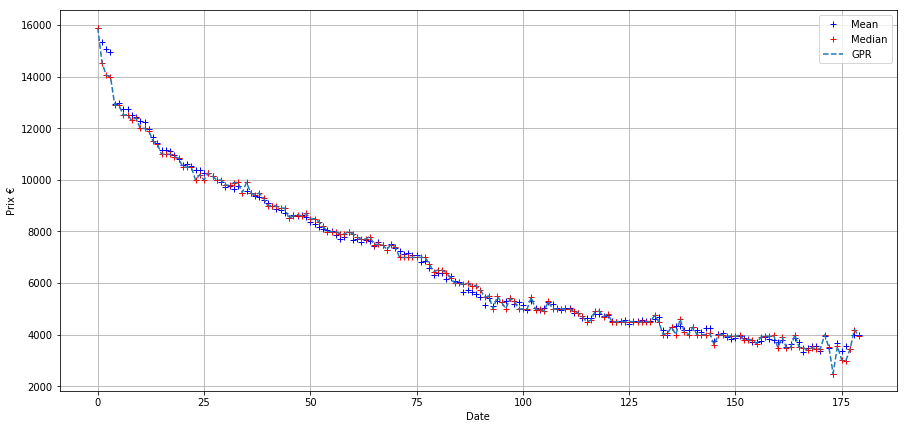

In [140]:
plt.figure(figsize=(15,7))
plt.plot(df_results.Age_months, df_results.Mean, 'b+', label='Mean')
plt.plot(df_results.Age_months, df_results.Median, 'r+', label='Median')
plt.plot(x_fin,y_GPR, '--',  label='GPR')
#plt.plot(x_fin,y_new2, '--',  label='LinearRegression')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Prix €')
plt.legend()
plt.show()

In [141]:
print(model1.score(X,y1))

1.0


<span style="color:blue"><font size="5">6 - Decision Trees Regression </font></span>

In [142]:
from sklearn import tree

In [143]:
model1 = tree.DecisionTreeRegressor()

In [144]:
#X_1 = np.array([i[0] for i in X])
#y1 = np.array(y1).reshape((len(y1), 1))
#print(len(X_1))
#print(len(y1))

y_DTR = model1.fit(X, y1).predict(x_new)

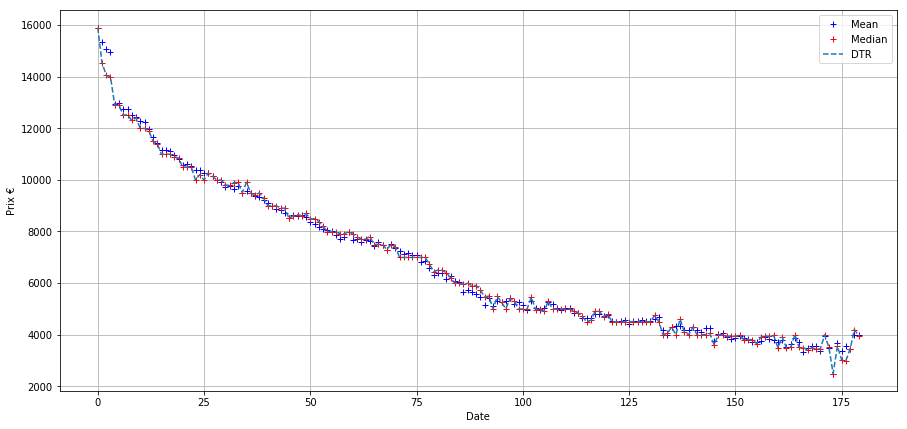

In [145]:
plt.figure(figsize=(15,7))
plt.plot(df_results.Age_months, df_results.Mean, 'b+', label='Mean')
plt.plot(df_results.Age_months, df_results.Median, 'r+', label='Median')
plt.plot(x_fin,y_DTR, '--',  label='DTR')
#plt.plot(x_fin,y_new2, '--',  label='LinearRegression')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Prix €')
plt.legend()
plt.show()

In [146]:
print(model1.score(X,y1))

1.0


<span style="color:blue"><font size="5">7 - Isotonic Regression </font></span>

In [147]:
from sklearn.isotonic import IsotonicRegression

In [152]:
X1 = df_results.Age_months.values
model1 = IsotonicRegression()
X1_1 = np.array(X1).reshape(len(X1),)
y1_1 = np.array(y1).reshape(len(y1),)
y_DTR = model1.fit(X1_1, y1_1).predict(x_new.reshape(len(x_new),))

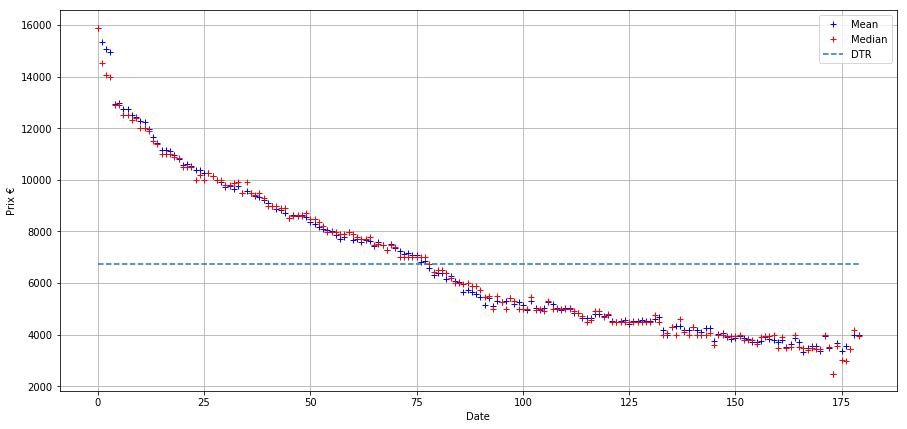

In [153]:
plt.figure(figsize=(15,7))
plt.plot(df_results.Age_months, df_results.Mean, 'b+', label='Mean')
plt.plot(df_results.Age_months, df_results.Median, 'r+', label='Median')
plt.plot(x_fin,y_DTR, '--',  label='DTR')
#plt.plot(x_fin,y_new2, '--',  label='LinearRegression')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Prix €')
plt.legend()
plt.show()

<span style="color:blue"><font size="5">7 - Univariate feature selection</font></span>

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import feature_selection

In [ ]:
head = list(df_select)
print(head)
X_train = df_select[[head[2],head[7],head[8],head[14]]]
#a = 
#X_train[head[8]] = X_train[head[8]].astype(int)

print(df_select[['CARROSSERIE_CORRECTED','CARBURANT_CORRECTED','BOITE_CORRECTED', 'PORTE_CORRECTED','4RM']][:5])
X_train2 = df_select[[head[2],head[7],head[8],head[14],\
                      'CARROSSERIE_CORRECTED','CARBURANT_CORRECTED','BOITE_CORRECTED', \
                      'PORTE_CORRECTED','4RM','PRIX']].dropna()
y1 = X_train2.PRIX



carr = list(X_train2['CARROSSERIE_CORRECTED'].unique())
carbu= list(X_train2['CARBURANT_CORRECTED'].unique())
boite= list(X_train2['BOITE_CORRECTED'].unique())
for i in range(len(carr)):
    X_train2['CARROSSERIE_CORRECTED'][X_train2['CARROSSERIE_CORRECTED']==carr[i]]=i+10 
for i in range(len(carbu)):
    X_train2['CARBURANT_CORRECTED'][X_train2['CARBURANT_CORRECTED']==carbu[i]]=i+20 
for i in range(len(boite)):
    X_train2['BOITE_CORRECTED'][X_train2['BOITE_CORRECTED']==boite[i]]=i +30
X_train2['PORTE_CORRECTED'] = X_train2['PORTE_CORRECTED'].astype(int)
X_train2 = X_train2[[head[2],head[7],head[8],head[14],'CARROSSERIE_CORRECTED',\
                     'CARBURANT_CORRECTED','BOITE_CORRECTED','PORTE_CORRECTED']]

print(X_train2.shape)

print(X_train2[:5])


In [ ]:
X_new = SelectKBest(chi2, k=3).fit_transform(X_train2, y1)
X_new2 = feature_selection.mutual_info_classif(X_train2, y1)

In [ ]:
print(X_new.shape)
print(X_new[:5])

KM - puissance - age 

In [ ]:
#print(X_new2.shape)
print(X_new2[:5])

<span style="color:blue"><font size="5">8 - Feature selection</font></span>

<span style="color:red"><font size="4">1. Univariate Selection</font></span>

Statistical tests can be used to select those features that have the strongest relationship with the output variable.

The scikit-learn library provides the SelectKBest class that can be used with a suite of different statistical tests to select a specific number of features.

The example below uses the chi squared (chi^2) statistical test for non-negative features to select 4 of the best features from the Pima Indians onset of diabetes dataset.

In [ ]:
#http://machinelearningmastery.com/feature-selection-machine-learning-python/
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [ ]:
# feature extraction
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(X_train2, y1)

In [ ]:
np.set_printoptions(precision=3)
print(fit.scores_)
# score for each column in the df (same order)
# 'KM', 'LITRE', 'PUISSANCE', 'AGE', 'CARROSSERIE','CARBURANT','BOITE', 'PORTE'
features = fit.transform(X_train2)
# summarize selected features
print(features[0:5,:])

<span style="color:red"><font size="4">2. Recursive Feature Elimination</font></span>

The Recursive Feature Elimination (or RFE) works by recursively removing attributes and building a model on those attributes that remain.

It uses the model accuracy to identify which attributes (and combination of attributes) contribute the most to predicting the target attribute.

You can learn more about the RFE class in the scikit-learn documentation.

The example below uses RFE with the logistic regression algorithm to select the top 3 features. The choice of algorithm does not matter too much as long as it is skillful and consistent.

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [ ]:
model = LogisticRegression()
rfe = RFE(model, 3)

In [ ]:
fit = rfe.fit(X_train2, y1)

In [ ]:
print("Num Features: %d") % fit.n_features_
print("Selected Features: %s") % fit.support_
print("Feature Ranking: %s") % fit.ranking_

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and weights are assigned to each one of them. Then, features whose absolute weights are the smallest are pruned from the current set features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.
RFECV performs RFE in a cross-validation loop to find the optimal number of features.

<span style="color:red"><font size="4">3. Principal Component Analysis</font></span>

Principal Component Analysis (or PCA) uses linear algebra to transform the dataset into a compressed form.

Generally this is called a data reduction technique. A property of PCA is that you can choose the number of dimensions or principal component in the transformed result.

In the example below, we use PCA and select 3 principal components.

Learn more about the PCA class in scikit-learn by reviewing the PCA API. Dive deeper into the math behind PCA on the Principal Component Analysis Wikipedia article.

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# feature extraction
pca = PCA(n_components=3)
fit = pca.fit(X_train2)
# summarize components
#print("Explained Variance: %s") % fit.explained_variance_ratio_
print(fit.explained_variance_ratio_)
print(fit.components_)
# 'KM', 'LITRE', 'PUISSANCE', 'AGE', 'CARROSSERIE','CARBURANT','BOITE', 'PORTE'

You can see that the transformed dataset (3 principal components) bare little resemblance to the source data.

<span style="color:red"><font size="4">4. Feature Importance</font></span>

Bagged decision trees like Random Forest and Extra Trees can be used to estimate the importance of features.

In the example below we construct a ExtraTreesClassifier classifier for the Pima Indians onset of diabetes dataset. You can learn more about the ExtraTreesClassifier class in the scikit-learn API.

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

In [ ]:
model = ExtraTreesClassifier()
model.fit(X_train2, y1)
print(model.feature_importances_)
# 'KM', 'LITRE', 'PUISSANCE', 'AGE', 'CARROSSERIE','CARBURANT','BOITE', 'PORTE'

You can see that we are given an importance score for each attribute where the larger score the more important the attribute. 

<span style="color:red"><font size="4">5. Incremental PCA</font></span>

In [ ]:
from sklearn.decomposition import IncrementalPCA

In [ ]:
ipca = IncrementalPCA(n_components=3, batch_size=3)
ipca.fit(X_train2)

In [ ]:
ipca.transform(X_train2) 

In [ ]:
print(ipca.explained_variance_ratio_)
print(ipca.components_)

<span style="color:red"><font size="4">6. SelectFromModel</font></span>

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

In [ ]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train2, y1)

In [ ]:
model = SelectFromModel(lsvc, prefit=True)